# Model Pre Training

### Idea 

Here we will use the contrastive learning approach [here](https://keras.io/examples/vision/simsiam/). Original paper is [here](https://arxiv.org/pdf/2011.10566.pdf)

## Data Processing

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

from keras_cv_attention_models import coatnet
from keras_cv_attention_models import swin_transformer_v2
from keras_cv_attention_models import nfnets
from keras_cv_attention_models import maxvit

from typing import List

In [2]:
TARGET_HEIGHT = 768
TARGET_WIDTH = 768

In [3]:
root_directory = '/data/CheXpert-v1.0'

In [4]:
train_folder = os.path.join(root_directory, 'train')
valid_folder = os.path.join(root_directory, 'valid')

In [5]:
train_labels_df = pd.read_csv(os.path.join(root_directory, 'train.csv'))
valid_labels_df = pd.read_csv(os.path.join(root_directory, 'valid.csv'))

In [6]:
train_labels_df.shape

(223414, 19)

In [7]:
valid_labels_df.shape

(234, 19)

## Contrastive learning hyperparameters

In [ ]:
BATCH_SIZE = 2
EPOCHS = 5
CROP_TO = 32
SEED = 26

PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005

### Defining our data augmentation pipeline

As studied in SimCLR having the right data augmentation pipeline is critical for SSL systems to work effectively in computer vision. Two particular augmentation transforms that seem to matter the most are: 1.) Random resized crops and 2.) Color distortions. Most of the other SSL systems for computer vision (such as BYOL, MoCoV2, SwAV, etc.) include these in their training pipelines.

In [ ]:
def apply_mask(image, size=12, n_squares=1):
    h, w, channels = image.shape
    new_image = np.asarray(image.copy())
    for _ in range(n_squares):
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - size // 2, 0, h)
        y2 = np.clip(y + size // 2, 0, h)
        x1 = np.clip(x - size // 2, 0, w)
        x2 = np.clip(x + size // 2, 0, w)
        new_image[y1:y2, x1:x2, :] = 0
    return new_image

In [ ]:
augmented = tf.image.random_brightness(img, max_delta=0.2)
augmented = tf.image.random_saturation(image=augmented, lower=0.8, upper=1.2)
augmented = tf.image.random_hue(image=augmented, max_delta=0.03)
augmented = tf.image.random_contrast(image=augmented, lower=0.8, upper=1.2)
image = tf.image.random_flip_left_right(image)

image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
image = tf.image.resize(image, target_height=TARGET_HEIGHT, target_width=TARGET_WIDTH)

In [ ]:
def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image

In [8]:
chexnet_targets = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

### Uncertainty Approaches
The CheXpert paper outlines several different approaches to mapping using the uncertainty labels in the data:

- Ignoring - essentially removing from the calculation in the loss function
- Binary mapping - sending uncertain values to either 0 or 1
- Prevalence mapping - use the rate of prevelance of the feature as it's target value
- Self-training - consider the uncertain values as unlabeled
- 3-Class Classification - retain a separate value for uncertain and try to predict it as a class in its own right

The paper gives the results of different experiments with the above approaches and indicates the most accurate approach for each feature.
    
|Approach/Feature|Atelectasis|Cardiomegaly|Consolidation|Edema|PleuralEffusion|
|-----------|-----------|-----------|-----------|-----------|-----------|
|`U-Ignore`|0.818(0.759,0.877)|0.828(0.769,0.888)|0.938(0.905,0.970)|0.934(0.893,0.975)|0.928(0.894,0.962)|
|`U-Zeros`|0.811(0.751,0.872)|0.840(0.783,0.897)|0.932(0.898,0.966)|0.929(0.888,0.970)|0.931(0.897,0.965)|
|`U-Ones`|**0.858(0.806,0.910)**|0.832(0.773,0.890)|0.899(0.854,0.944)|0.941(0.903,0.980)|0.934(0.901,0.967)|
|`U-Mean`|0.821(0.762,0.879)|0.832(0.771,0.892)|0.937(0.905,0.969)|0.939(0.902,0.975)|0.930(0.896,0.965)|
|`U-SelfTrained`|0.833(0.776,0.890)|0.831(0.770,0.891)|0.939(0.908,0.971)|0.935(0.896,0.974)|0.932(0.899,0.966)|
|`U-MultiClass`|0.821(0.763,0.879)|**0.854(0.800,0.909)**|0.937(0.905,0.969)|0.928(0.887,0.968)|0.936(0.904,0.967)|

The binary mapping approaches (U-Ones and U-Zeros) are easiest to implement and so to begin with we take the best option between U-Ones and U-Zeros for each feature

- Atelectasis `U-Ones`
- Cardiomegaly `U-Zeros`
- Consolidation `U-Zeros`
- Edema `U-Ones`
- Pleural Effusion `U-Zeros`

In [9]:
# Old approach

# u_one_features = ['Atelectasis', 'Edema']
# u_zero_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']

In [10]:
# New approach: use 1 as positive and everything else and negative

u_one_features = []
u_zero_features = chexnet_targets 

In [11]:
def label_u_one_features(df: pd.DataFrame, column: str):
    return np.where((df[column] == 1) | (df[column] == -1), 1, 0)

def label_u_zero_features(df: pd.DataFrame, column: str):
    return np.where(df[column] == 1, 1, 0)

In [12]:
train_labels_df['valid'] = False
valid_labels_df['valid'] = True

In [13]:
train_labels_df

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,CheXpert-v1.0/train/patient64537/study2/view1_...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN,False
223410,CheXpert-v1.0/train/patient64537/study1/view1_...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN,False
223411,CheXpert-v1.0/train/patient64538/study1/view1_...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
223412,CheXpert-v1.0/train/patient64539/study1/view1_...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,0.0,NaN,NaN,NaN,0.0,False


In [14]:
train_labels_df['patient'] = train_labels_df.Path.str.split('/',3,True)[2]
train_labels_df  ['study'] = train_labels_df.Path.str.split('/',4,True)[3]

valid_labels_df['patient'] = valid_labels_df.Path.str.split('/',3,True)[2]
valid_labels_df  ['study'] = valid_labels_df.Path.str.split('/',4,True)[3]

<ipython-input-14-8f93b41370de>:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  train_labels_df['patient'] = train_labels_df.Path.str.split('/',3,True)[2]
<ipython-input-14-8f93b41370de>:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  train_labels_df  ['study'] = train_labels_df.Path.str.split('/',4,True)[3]
<ipython-input-14-8f93b41370de>:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  valid_labels_df['patient'] = valid_labels_df.Path.str.split('/',3,True)[2]
<ipython-input-14-8f93b41370de>:5: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  valid_labels_df  ['study'] = valid_labels_df.Path.str.split('/',4,True)[3]


In [15]:
train_labels_df

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,patient,study
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,CheXpert-v1.0/train/patient64537/study2/view1_...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,...,NaN,-1.0,0.0,1.0,NaN,NaN,NaN,False,patient64537,study2
223410,CheXpert-v1.0/train/patient64537/study1/view1_...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,...,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN,False,patient64537,study1
223411,CheXpert-v1.0/train/patient64538/study1/view1_...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,patient64538,study1
223412,CheXpert-v1.0/train/patient64539/study1/view1_...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,...,-1.0,1.0,0.0,NaN,NaN,NaN,0.0,False,patient64539,study1


In [16]:
full_df = pd.concat([train_labels_df, valid_labels_df])
full_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,patient,study
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1


In [17]:
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [18]:
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')
full_df['feature_string'] = full_df['feature_string'].apply(lambda x:x.split(";"))

In [19]:
for col in u_one_features:
    full_df[f'{col}_u_one'] = label_u_one_features(df=full_df, column=col)
for col in u_zero_features:
    full_df[f'{col}_u_zero'] = label_u_zero_features(df=full_df, column=col)

In [20]:
full_df.head(10)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Lung Lesion_u_zero,Edema_u_zero,Consolidation_u_zero,Pneumonia_u_zero,Atelectasis_u_zero,Pneumothorax_u_zero,Pleural Effusion_u_zero,Pleural Other_u_zero,Fracture_u_zero,Support Devices_u_zero
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,0,0,0,0,0,0,0,0,1,0
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,0,0,0,0,0,0,0,0,1,0
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,0,0,0,0,0,0,0,0,1,0
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
5,CheXpert-v1.0/train/patient00004/study1/view1_...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
6,CheXpert-v1.0/train/patient00004/study1/view2_...,Female,20,Lateral,NaN,1.0,0.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
7,CheXpert-v1.0/train/patient00005/study1/view1_...,Male,33,Frontal,PA,1.0,NaN,0.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
8,CheXpert-v1.0/train/patient00005/study1/view2_...,Male,33,Lateral,NaN,1.0,NaN,0.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
9,CheXpert-v1.0/train/patient00005/study2/view1_...,Male,33,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0


In [21]:
full_df['path'] = '/data/' + full_df['Path']

In [22]:
full_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Edema_u_zero,Consolidation_u_zero,Pneumonia_u_zero,Atelectasis_u_zero,Pneumothorax_u_zero,Pleural Effusion_u_zero,Pleural Other_u_zero,Fracture_u_zero,Support Devices_u_zero,path
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,/data/CheXpert-v1.0/train/patient00001/study1/...
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,0,0,0,0,0,0,0,1,0,/data/CheXpert-v1.0/train/patient00002/study2/...
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,0,0,0,0,0,0,0,1,0,/data/CheXpert-v1.0/train/patient00002/study1/...
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,0,0,0,0,0,0,0,1,0,/data/CheXpert-v1.0/train/patient00002/study1/...
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,/data/CheXpert-v1.0/train/patient00003/study1/...


In [23]:
# Old targets
# targets = ['Atelectasis_u_one', 'Edema_u_one', 'Cardiomegaly_u_zero', 'Consolidation_u_zero', 'Pleural Effusion_u_zero']

# New targets
targets = [target + '_u_zero' for target in u_zero_features]

In [24]:
X_train = full_df['path'][~full_df['valid']].values
y_train = full_df[targets][~full_df['valid']].values
X_val = full_df['path'][full_df['valid']].values
y_val = full_df[targets][full_df['valid']].values

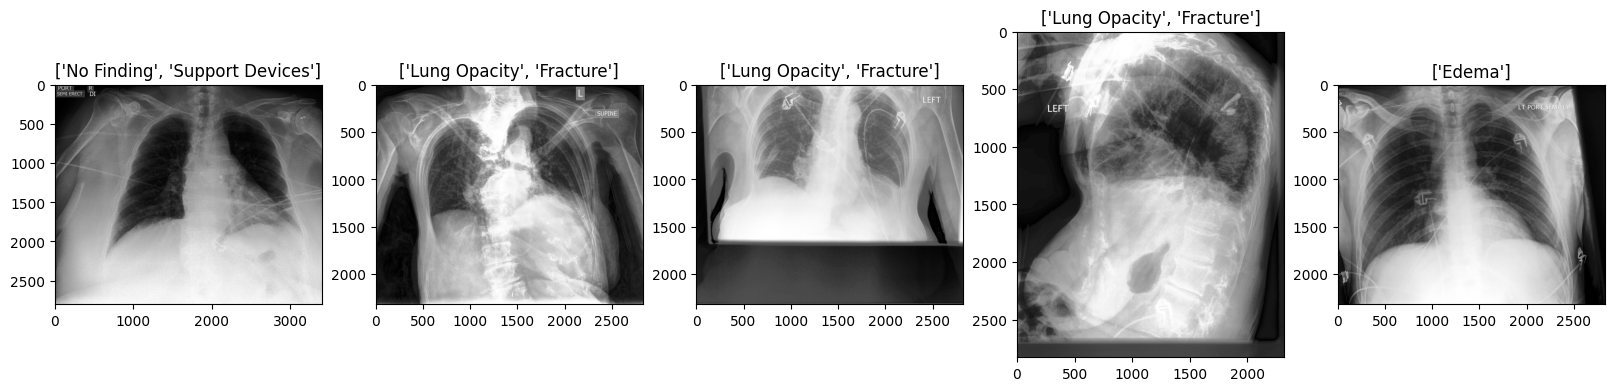

In [25]:
#get the first 5 images
paths =  full_df.path[:5]
labels = full_df.feature_string[:5]

fig, m_axs = plt.subplots(1, len(labels), figsize = (20, 10))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(np.asarray(Image.open(paths[ii])), cmap='gray')
    c_ax.set_title(labels[ii])
plt.show()

## Original Image

In [26]:
img = np.asarray(Image.open(X_val[0]))

In [27]:
img = np.stack((img,)*3, axis=-1)

In [28]:
img.shape

(2320, 2828, 3)

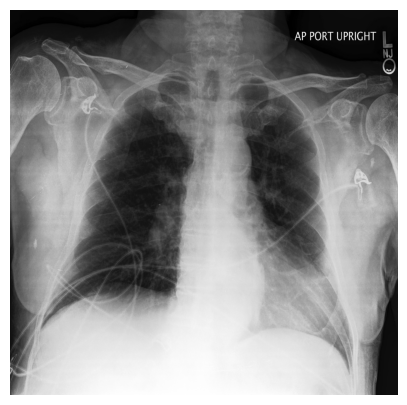

In [29]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(img)
ax.axis('off')
ax.set_aspect('auto')

plt.show() 

## Augmented Image

In [30]:
def apply_mask(image, size=12, n_squares=1):
    h, w, channels = image.shape
    new_image = np.asarray(image.copy())
    for _ in range(n_squares):
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - size // 2, 0, h)
        y2 = np.clip(y + size // 2, 0, h)
        x1 = np.clip(x - size // 2, 0, w)
        x2 = np.clip(x + size // 2, 0, w)
        new_image[y1:y2, x1:x2, :] = 0
    return new_image

In [31]:
if np.random.uniform() < 0.5:
    augmented = apply_mask(img, size=np.random.randint(low=70, high=240), n_squares=np.random.randint(low=2, high=12))
else:
    augmented = tf.image.random_brightness(img, max_delta=0.2)
    augmented = tf.image.random_saturation(image=augmented, lower=0.8, upper=1.2)
    augmented = tf.image.random_hue(image=augmented, max_delta=0.03)
    augmented = tf.image.random_contrast(image=augmented, lower=0.8, upper=1.2)
# augmented = tf.image.random_flip_up_down(img)
# augmented = tf.image.random_flip_left_right(img)
# augmented = tf.image.random_saturation(image=img, lower=0.7, upper=1.3)
# augmented = tf.image.random_hue(image=img, max_delta=0.03)
# augmented = tf.image.random_contrast(image=img, lower=0.7, upper=1.3)

In [32]:
augmented.shape

(2320, 2828, 3)

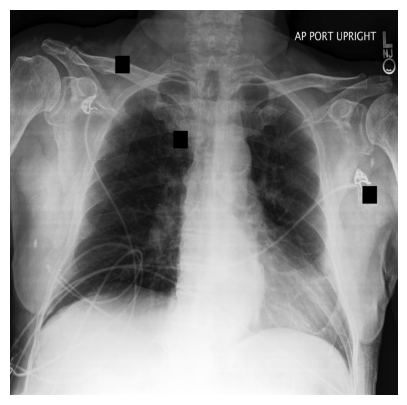

In [33]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(augmented, cmap='gray')
ax.axis('off')
ax.set_aspect('auto')

plt.show() 

In [34]:
NUM_TRAIN = len(X_train)

## Determine class weights 

In [35]:
target_columns = [col_name + '_label' for col_name in targets]

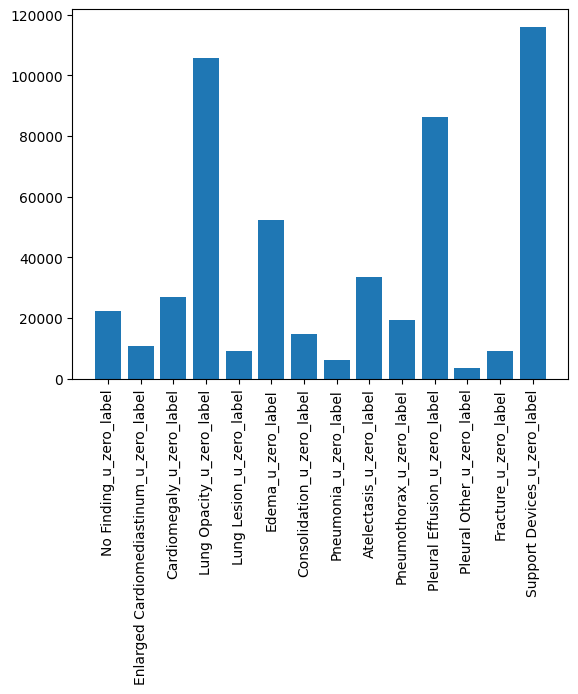

In [36]:
plt.xticks(rotation=90)
plt.bar(x=target_columns, height=y_train.sum(axis=0))
plt.show()

In [37]:
class_counts = y_train.sum(axis=0)
total_count = y_train.sum()

In [38]:
cls_weights = {i: total_count/class_i_count for i, class_i_count in enumerate(class_counts)}

In [39]:
cls_weights

{0: 23.03690630445467,
 1: 47.74856454899055,
 2: 19.09588888888889,
 3: 4.883350223998636,
 4: 56.127694317439584,
 5: 9.868487539715959,
 6: 34.8771561929243,
 7: 85.3765524093393,
 8: 15.447896692233941,
 9: 26.51115795968737,
 10: 5.982213094782276,
 11: 146.3494181095657,
 12: 57.034181415929204,
 13: 4.444694442289291}

In [40]:
cls_weights_sqrt = {i: np.sqrt(weight) for i, weight in enumerate(list(cls_weights.values()))}

In [41]:
cls_weights_sqrt

{0: 4.799677729228773,
 1: 6.91003361417226,
 2: 4.369884310698498,
 3: 2.209830360909777,
 4: 7.491841850802751,
 5: 3.1414148945524465,
 6: 5.905688460537374,
 7: 9.239943312019793,
 8: 3.9303812400623355,
 9: 5.148898713286888,
 10: 2.4458563111479537,
 11: 12.097496357080075,
 12: 7.552097815569473,
 13: 2.108244398140142}

In [42]:
cls_weights_log = {i: np.log(weight) for i, weight in enumerate(list(cls_weights.values()))}

In [43]:
cls_weights_log

{0: 3.137097551831732,
 1: 3.865949004673629,
 2: 2.9494730704653955,
 3: 1.585831505628296,
 4: 4.027629350566123,
 5: 2.289346603579213,
 6: 3.5518320645507715,
 7: 4.44707150114396,
 8: 2.7374728576513627,
 9: 3.277565699455902,
 10: 1.7887905822383254,
 11: 4.985997037110624,
 12: 4.0436507620656394,
 13: 1.4917111247108628}

In [44]:
y_train_weighted = y_train * np.array(list(cls_weights.values()))

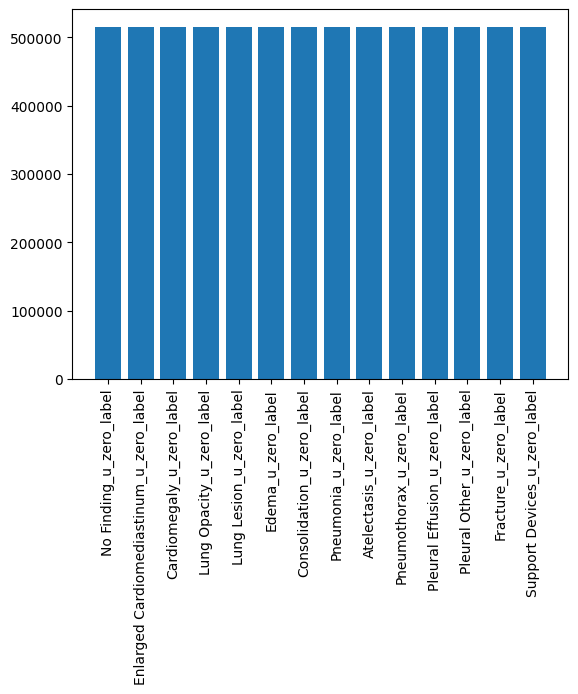

In [45]:
plt.xticks(rotation=90)
plt.bar(x=target_columns, height=y_train_weighted.sum(axis=0))
plt.show()

In [46]:
y_train_weighted_sqrt = y_train * np.array(list(cls_weights_sqrt.values()))

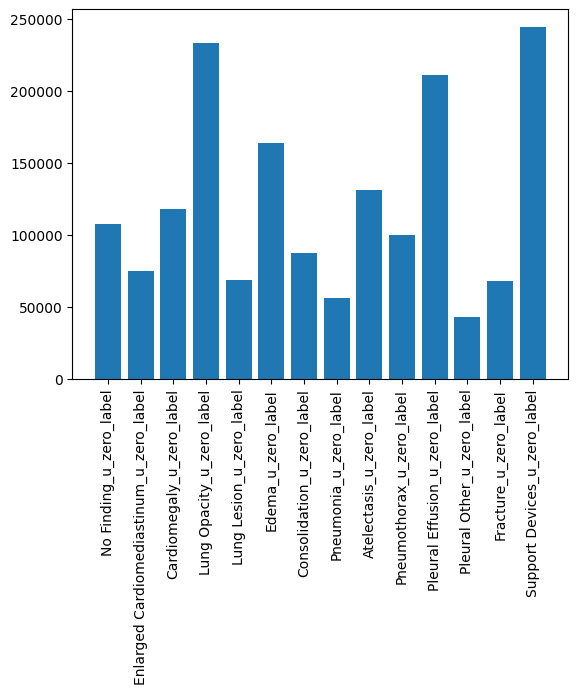

In [47]:
plt.xticks(rotation=90)
plt.bar(x=target_columns, height=y_train_weighted_sqrt.sum(axis=0))
plt.show()

In [48]:
y_train_weighted_log = y_train * np.array(list(cls_weights_log.values()))

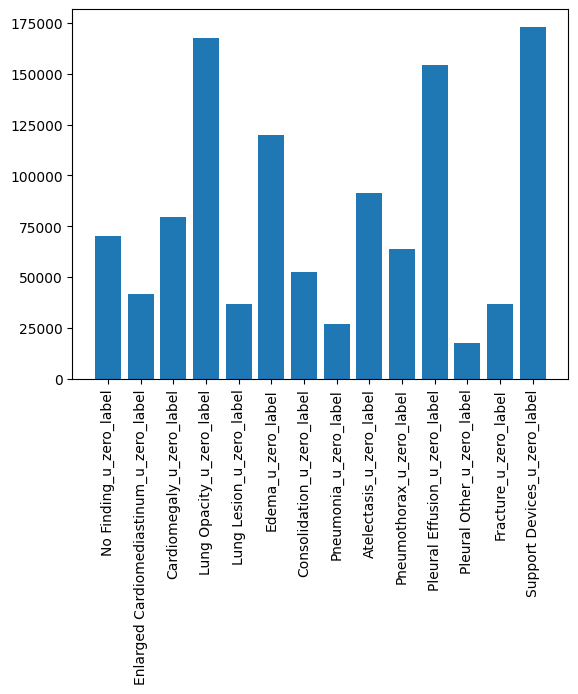

In [49]:
plt.xticks(rotation=90)
plt.bar(x=target_columns, height=y_train_weighted_log.sum(axis=0))
plt.show()

In [50]:
USE_CLASS_WEIGHTS = True

In [51]:
if USE_CLASS_WEIGHTS:
    CLASS_WEIGHTS = cls_weights_sqrt
else:
    CLASS_WEIGHTS = None

In [52]:
def convert_image_to_array(path):
    img = np.asarray(Image.open(path), dtype=np.float32)
    img = np.stack((img,)*3, axis=-1)
    img /= 255.
    img = tf.image.resize_with_pad(img, target_height=TARGET_HEIGHT, target_width=TARGET_WIDTH)
    return img

In [53]:
def create_model_file(X_path, y):
    """
    X_path: (pandas series) contains the file paths to the images
    y: (pandas series of type int) the target label
    
    return a pair of numpy arrays representing (features, target)
    """
    
    X = pd.Series(X_path).apply(convert_image_to_array)
    X = X.values
    X = list(X)
    X = np.array(X, dtype='float32')
    
    return (X, y)

In [54]:
def model_predict(path, model):
    x = convert_image_to_array(path=path)
    x = np.expand_dims(x, axis=0)
    return model.predict(x)

In [55]:
val_data = create_model_file(X_path=X_val, y=y_val)

In [56]:
val_data[0].shape

(234, 640, 640, 3)

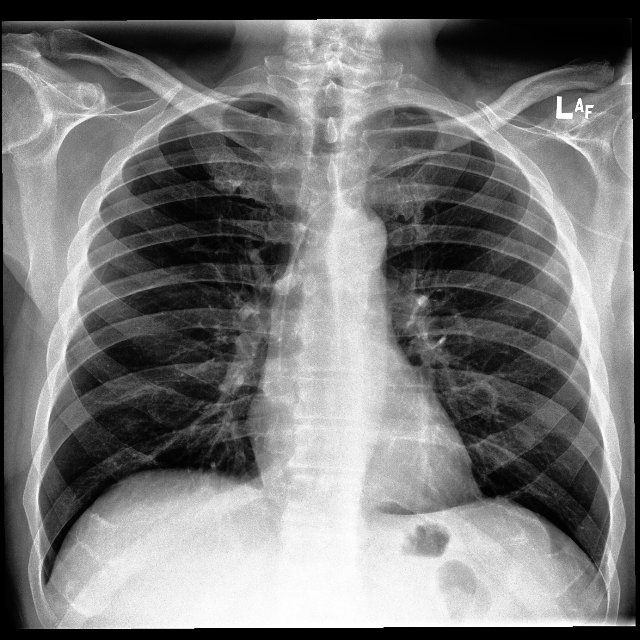

In [57]:
Image.fromarray(np.uint8(255 * val_data[0][1]))

Create a data generator for training

In [58]:
num_classes = y_train.shape[1]

In [59]:
def data_gen(X, y, batch_size, image_size=(TARGET_HEIGHT, TARGET_WIDTH), dtype=np.float32):
    # Get total number of samples in the data
    n = len(X)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, image_size[0], image_size[1], 3), dtype=dtype)
    batch_labels = np.zeros((batch_size, num_classes), dtype=dtype)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i = 0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_path = X[idx]
            label = y[idx]
            
            # one hot encoding
            encoded_label = label
            # read the image
            img = np.asarray(Image.open(img_path), dtype=dtype)
            img = np.stack((img,)*3, axis=-1)
            
            # add image augmentation
            if np.random.uniform() < 0.65:
                img = apply_mask(img, size=np.random.randint(low=70, high=240), n_squares=np.random.randint(low=2, high=12))
            else:
                if np.random.uniform() < 0.15:
                    img = tf.image.random_brightness(img, max_delta=0.2)
    #             if np.random.uniform() < 0.15:
    #                 img = tf.image.random_flip_up_down(img)
    #             if np.random.uniform() < 0.15:
    #                 img = tf.image.random_flip_left_right(img)
                if np.random.uniform() < 0.15:
                    img = tf.image.random_saturation(image=img, lower=0.8, upper=1.2)
                if np.random.uniform() < 0.15:
                    img = tf.image.random_hue(image=img, max_delta=0.03)
                if np.random.uniform() < 0.15:
                    img = tf.image.random_contrast(image=img, lower=0.8, upper=1.2)
            
            img = img/255.
            
            # resize image
            img = tf.image.resize_with_pad(img, target_height=image_size[0], target_width=image_size[1])
            
            batch_data[count] = img
            batch_labels[count] = encoded_label

            count+=1

            if count==batch_size:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

## Keras Utility Functions

Define some functions that will help simplify the fine-tuning pre-trained models

In [60]:
def freeze_layers(model, freeze_layer_name):
    for layer in model.layers:
        if layer.name != freeze_layer_name:
            layer.trainable = False
        else:
            layer.trainable = False
            break
            
def unfreeze_batch_norm(model):
    for layer in model.layers:
        if layer.__class__.__name__ == 'BatchNormalization':
            layer.trainable = True
            
def unfreeze_layer_norm(model):
    for layer in model.layers:
        if layer.__class__.__name__ == 'LayerNormalization':
            layer.trainable = True

def print_layer_trainable(model):
    for layer in model.layers:
        print('{0}:\t{1}'.format(layer.trainable, layer.name))

## Build the model

In [61]:
# model = swin_transformer_v2.SwinTransformerV2Base_window24(input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3))

353638232/353638232 [==============================] - 5s 0us/step
>>>> Load pretrained from: /root/.keras/models/swin_transformer_v2_base_window24_384_imagenet22k.h5


In [124]:
# model = coatnet.CoAtNet2(input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3))

In [137]:
# model = nfnets.ECA_NFNetL3(input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3))

In [154]:
model = maxvit.MaxViT_Small(input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3))

279100792/279100792 [==============================] - 4s 0us/step
>>>> Load pretrained from: /root/.keras/models/maxvit_small_512_imagenet.h5
>>>> Reload mismatched weights: 512 -> (640, 640)
>>>> Reload layer: stack_1_block_1/block_window_mhsa/pos_emb
>>>> Reload layer: stack_1_block_1/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_1_block_2/block_window_mhsa/pos_emb
>>>> Reload layer: stack_1_block_2/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_2_block_1/block_window_mhsa/pos_emb
>>>> Reload layer: stack_2_block_1/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_2_block_2/block_window_mhsa/pos_emb
>>>> Reload layer: stack_2_block_2/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_1/block_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_1/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_2/block_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_2/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_3/block_window_mhsa/pos_emb
>>>> Reload layer: s

In [162]:
model.layers[-6].name

'stack_4_block_2/grid_ffn_output'

In [163]:
model.count_params()

69339956

## Load Pretrained Model (alternative)

In [65]:
# # model_path='./serialized_models/pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.3887.h5'
# model_path='./serialized_models/pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.4021.h5'
# # model_path='./serialized_models/pretrain_model_ConvNeXtSmall_w_ClssWgt_03-0.5216.h5'

In [66]:
# from keras.applications.convnext import LayerScale
# model = tf.keras.models.load_model(model_path, custom_objects={'LayerScale': LayerScale})

Determine where to freeze and cut off base model

In [67]:
# # Note: these were used to train SwinTransformerV2Base_window24
# transfer_layer_name = 'pre_output_ln'
# transfer_layer = model.get_layer(transfer_layer_name)

In [125]:
# # Note: these were used to train CoAtNet2
# transfer_layer_name = 'stack_4_block_2_ffn_output'
# transfer_layer = model.get_layer(transfer_layer_name)

In [164]:
# # Note: these were used to train ECA_NFNetL3
# transfer_layer_name = 'post_swish'
# transfer_layer = model.get_layer(transfer_layer_name)

In [165]:
# # Note: these were used to train MaxViT_Small
transfer_layer_name = 'stack_4_block_2/grid_ffn_output'
transfer_layer = model.get_layer(transfer_layer_name)

In [166]:
# model.summary()

In [167]:
conv_model = tf.keras.Model(inputs=model.input, outputs=transfer_layer.output)

In [168]:
def build_model(base_model, num_classes, pooling='avg', final_conv_layer='vgg_separable', expand_model=True, dropout_rate=0):
    # Get the output of the base model on which we will build
    x = base_model.layers[-1].output
    
    if expand_model:
        if final_conv_layer == 'xception':
            x = layers.SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
            x = layers.BatchNormalization(name='block14_sepconv2_bn')(x)
            x = layers.Activation('relu', name='block14_sepconv2_act')(x)
            x = keras.layers.Dropout(dropout_rate / 2)(x)
        elif final_conv_layer == 'non_separable':
            x = layers.Conv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_conv2')(x)
            x = layers.BatchNormalization(name='block14_conv2_bn')(x)
            x = layers.Activation('relu', name='block14_conv2_act')(x)
            x = keras.layers.Dropout(dropout_rate / 2)(x)
        elif final_conv_layer == 'vgg_separable':
            x = layers.SeparableConv2D(2048, (3,3), activation='relu', padding='same', kernel_regularizer='l1_l2', bias_regularizer='l1_l2', name='block14_sepconv2')(x)
            x = keras.layers.Dropout(dropout_rate / 2)(x)
        elif final_conv_layer == 'vgg':
            x = layers.Conv2D(2048, (3,3), activation='relu', padding='same', name='block14_sepconv2')(x)
            x = keras.layers.Dropout(dropout_rate / 2)(x)
        else:
            raise ValueError('`final_conv_layer` should be one of the following: xception, non_separable, vgg_separable, or vgg')

    if pooling == 'global_avg':
        x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    elif pooling == 'global_max':
        x = layers.GlobalMaxPooling2D(name='global_max_pool')(x)
    elif pooling == 'max':
        x = layers.MaxPooling2D((2,2), name='local_max_pool')(x)
        x = layers.Flatten(name='flatten')(x)
    elif pooling == 'avg':
        x = layers.AveragePooling2D((2,2), name='local_avg_pool')(x)
        x = layers.Flatten(name='flatten')(x)
    else:
        pass
    x = keras.layers.Dropout(dropout_rate)(x)
        
    x = layers.Dense(num_classes, activation='sigmoid', name='prediction')(x)

    # Create model.
    model = tf.keras.Model(base_model.input, x, name='Xception')
    return model

## Determine good starting learning rate

Experiment with the proper learning rate range by starting at a low number, see how many epochs for loss to get to a certain value, incrementally increase until the learning rate is too high. Use this range to determine the initial learning rate.

Create a function to do this analysis

In [90]:
def determine_learning_rate(X, y, batch_size: int, lr_list: List[float], steps: int):
    train_loss_by_lr = []
    
    for i, lr in enumerate(lr_list):
        print(f'Learning rate {i + 1} of {len(lr_list)}. LR value: {lr}')
        local_model = ConvNeXtBase(include_top=False, weights='imagenet', input_tensor=input_tensor, include_preprocessing=False)
        local_conv_model = tf.keras.Model(inputs=local_model.input, outputs=local_model.output)
        
        model_lr = build_model(base_model=local_conv_model, num_classes=num_classes, dropout_rate=0.3)
        
        model_lr.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss="binary_crossentropy",
            metrics=["accuracy"],
        )
        
        hist = model_lr.fit(
            x=data_gen(X=X, y=y, batch_size=batch_size), 
            epochs=1, 
            steps_per_epoch=steps,
            class_weight=CLASS_WEIGHTS,
        )
        
        final_loss = hist.history['loss'][-1]
        final_acc = hist.history['accuracy'][-1]
        
        train_loss_by_lr.append((lr, final_loss, final_acc))
      
    losses_df = pd.DataFrame(train_loss_by_lr, columns=['learning_rate', 'training_loss', 'training_accuracy'])
    
    return losses_df

In [91]:
# lr_loss_df = determine_learning_rate(X=X_train, 
#                                      y=y_train, 
#                                      batch_size=2, 
#                                      lr_list=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 1e-7, 1e-8,],
#                                      steps=200)

In [92]:
# plt.scatter(x=lr_loss_df['learning_rate'].values, y=lr_loss_df['training_loss'].values)
# plt.xscale('log')
# plt.show()

## Train model

In [93]:
# Ideally retrain the entire model, but memory is constrained 
# freeze_layers(conv_model, freeze_layer_name)

In [169]:
model = build_model(base_model=conv_model, num_classes=num_classes, dropout_rate=0.3)

In [170]:
# model.summary()

In [171]:
unfreeze_batch_norm(model)

In [172]:
unfreeze_layer_norm(model)

In [173]:
print_layer_trainable(model)

True:	input_7
True:	stem_1_conv
True:	stem_1_bn
True:	tf.nn.gelu_45
True:	stem_2_conv
True:	stack_1_block_1/mbconv/preact_bn
True:	stack_1_block_1/mbconv/expand_pad
True:	stack_1_block_1/mbconv/expand_conv
True:	stack_1_block_1/mbconv/expand_bn
True:	tf.nn.gelu_46
True:	stack_1_block_1/mbconv/MB_dw_conv
True:	stack_1_block_1/mbconv/MB_dw_bn
True:	tf.nn.gelu_47
True:	tf.math.reduce_mean_123
True:	stack_1_block_1/mbconv/se/1_conv
True:	stack_1_block_1/mbconv/se/swish
True:	stack_1_block_1/mbconv/se/2_conv
True:	stack_1_block_1/mbconv/se/sigmoid
True:	stack_1_block_1/mbconv/se/out
True:	stack_1_block_1/mbconv/shortcut_pool
True:	stack_1_block_1/mbconv/MB_pw_pad
True:	stack_1_block_1/mbconv/shortcut_conv
True:	stack_1_block_1/mbconv/MB_pw_conv
True:	stack_1_block_1/mbconv/output
True:	stack_1_block_1/block_attn_preact_ln
True:	tf.reshape_548
True:	tf.compat.v1.transpose_453
True:	tf.reshape_549
True:	stack_1_block_1/block_window_mhsa/qkv_conv
True:	tf.split_78
True:	tf.reshape_550
True:	tf

## Lion Optimizer

[Lion](https://arxiv.org/pdf/2302.06675.pdf) is a new optimizer that helps to converge more quickly to better models with better memory efficiency. The official implementation is [here](https://github.com/google/automl/blob/master/lion/lion_tf2.py).

In [147]:
class Lion(tf.keras.optimizers.legacy.Optimizer):
  r"""Optimizer that implements the Lion algorithm."""

  def __init__(self,
               learning_rate=0.0001,
               beta_1=0.9,
               beta_2=0.99,
               wd=0,
               name='lion',
               **kwargs):
    """Construct a new Lion optimizer."""

    super(Lion, self).__init__(name, **kwargs)
    self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
    self._set_hyper('beta_1', beta_1)
    self._set_hyper('beta_2', beta_2)
    self._set_hyper('wd', wd)

  def _create_slots(self, var_list):
    # Create slots for the first and second moments.
    # Separate for-loops to respect the ordering of slot variables from v1.
    for var in var_list:
      self.add_slot(var, 'm')

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(Lion, self)._prepare_local(var_device, var_dtype, apply_state)

    beta_1_t = tf.identity(self._get_hyper('beta_1', var_dtype))
    beta_2_t = tf.identity(self._get_hyper('beta_2', var_dtype))
    wd_t = tf.identity(self._get_hyper('wd', var_dtype))
    lr = apply_state[(var_device, var_dtype)]['lr_t']
    apply_state[(var_device, var_dtype)].update(
        dict(
            lr=lr,
            beta_1_t=beta_1_t,
            one_minus_beta_1_t=1 - beta_1_t,
            beta_2_t=beta_2_t,
            one_minus_beta_2_t=1 - beta_2_t,
            wd_t=wd_t))

  @tf.function(jit_compile=True)
  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
                    self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    var_t = var.assign_sub(
        coefficients['lr_t'] *
        (tf.math.sign(m * coefficients['beta_1_t'] +
                      grad * coefficients['one_minus_beta_1_t']) +
         var * coefficients['wd_t']))
    with tf.control_dependencies([var_t]):
      m.assign(m * coefficients['beta_2_t'] +
               grad * coefficients['one_minus_beta_2_t'])

  @tf.function(jit_compile=True)
  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
                    self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    m_t = m.assign(m * coefficients['beta_1_t'])
    m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
    m_t = m_t.scatter_add(tf.IndexedSlices(m_scaled_g_values, indices))
    var_t = var.assign_sub(coefficients['lr'] *
                           (tf.math.sign(m_t) + var * coefficients['wd_t']))

    with tf.control_dependencies([var_t]):
      m_t = m_t.scatter_add(tf.IndexedSlices(-m_scaled_g_values, indices))
      m_t = m_t.assign(m_t * coefficients['beta_2_t'] /
                       coefficients['beta_1_t'])
      m_scaled_g_values = grad * coefficients['one_minus_beta_2_t']
      m_t.scatter_add(tf.IndexedSlices(m_scaled_g_values, indices))

  def get_config(self):
    config = super(Lion, self).get_config()
    config.update({
        'learning_rate': self._serialize_hyperparameter('learning_rate'),
        'beta_1': self._serialize_hyperparameter('beta_1'),
        'beta_2': self._serialize_hyperparameter('beta_2'),
        'wd': self._serialize_hyperparameter('wd'),
    })
    return config

## Train the model

In [174]:
lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
      # initial_learning_rate=3e-3, # for uniform weighting
      # initial_learning_rate=3e-4, # for sqrt weighting 
      initial_learning_rate=1e-5, # lower learning rate for Lion optimizer
      first_decay_steps=int(NUM_TRAIN/ (7 * batch_size)))

In [175]:
# Cycle through cosine decay with restarts 7 times per epoch
print(NUM_TRAIN/ (7 * batch_size))
print(int(NUM_TRAIN/ (7 * batch_size)))

7979.071428571428
7979


In [177]:
epochs = 20
batch_size = 2
model_path='./serialized_models/pretrain_model_MaxViT_w_ClssWgt_{epoch:02d}-{val_loss:.4f}.h5'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=model_path, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=10)
]
model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    optimizer=Lion(learning_rate=lr_schedule),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    x=data_gen(X=X_train, y=y_train, batch_size=batch_size), 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_data=val_data, 
    validation_batch_size=4,
    steps_per_epoch=int(NUM_TRAIN/batch_size),
    class_weight=CLASS_WEIGHTS,
)

Epoch 1/20
111707/111707 [==============================] - ETA: 0s - loss: 1.1197 - accuracy: 0.1826

ResourceExhaustedError: Graph execution error:

Detected at node 'Xception/stack_1_block_1/mbconv/expand_conv/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 982, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 505, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 687, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 740, in _run_callback
      ret = callback()
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 821, in inner
      self.ctx_run(self.run)
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 782, in run
      yielded = self.gen.send(value)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 540, in execute_request
      self.do_execute(
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-177-ad424b4e5228>", line 15, in <module>
      model.fit(
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1694, in fit
      val_logs = self.evaluate(
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2040, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1820, in test_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1804, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1792, in run_step
      outputs = model.test_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1756, in test_step
      y_pred = self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional/base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional/base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'Xception/stack_1_block_1/mbconv/expand_conv/Conv2D'
OOM when allocating tensor with shape[32,384,320,320] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Xception/stack_1_block_1/mbconv/expand_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_18414861]

SwinV2: 1000/111707: loss: 1.446, accuracy: 0.0624
SwinV2: 8000/111707: loss: 1.376, accuracy: 0.0392
CoAtNet2: 1000/111707: loss: 1.468, accuracy: 0.0750
CoAtNet2: 4200/111707: loss: 1.371, accuracy: 0.0840
NFNet (w/ Lion): 500/55853: loss: 1.465, accuracy: 0.0319
NFNet (w/ Lion): 2100/55853: loss: 1.37, accuracy: 0.0433
NFNet (w/ Lion): 4673/55853: loss: 1.33, accuracy: 0.0596
MaxViT (w/ Lion): 500/111707: loss: 1.465, accuracy: 0.0319
MaxViT (w/ Lion): 5500/111707: loss: 1.247, accuracy: 0.1242
MaxViT (w/ Lion): 13500/111707: loss: 1.196, accuracy: 0.15

Old convnet: 13300/55853, loss: 0.3006, accuracy: 0.2011

Save final model - Make sure name is correct!

In [212]:
model.save('./serialized_models/pretrain_model_MaxViT_w_ClssWgt_01-0.unk.h5')

## Evaluate model performance

### TODO
- Move all these utility function to a python script instead

Load specific model (optional)

In [184]:
model.evaluate(x=val_data[0], y=val_data[1], batch_size=2)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Load model from disk

In [123]:
from keras.applications.convnext import LayerScale

In [124]:
model_path='./serialized_models/pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.3616.h5'

In [125]:
model = tf.keras.models.load_model(model_path, custom_objects={'LayerScale': LayerScale})

In [210]:
MODEL_NAME = 'pretrain_model_MaxViT_w_ClssWgt_01-0.unk.h5'

Get all predictions

In [178]:
pred_columns = [col_name + '_pred' for col_name in targets]
target_columns = [col_name + '_label' for col_name in targets]

In [179]:
all_model_preds = pd.DataFrame(0, index=np.arange(len(X_val)), columns=pred_columns)

In [180]:
for i, path in enumerate(X_val):
    all_model_preds.iloc[i, :] = model_predict(path=path, model=model)[0]

1/1 [==============================] - 0s 141ms/step


In [185]:
all_model_preds

,No Finding_u_zero_pred,Enlarged Cardiomediastinum_u_zero_pred,Cardiomegaly_u_zero_pred,Lung Opacity_u_zero_pred,Lung Lesion_u_zero_pred,Edema_u_zero_pred,Consolidation_u_zero_pred,Pneumonia_u_zero_pred,Atelectasis_u_zero_pred,Pneumothorax_u_zero_pred,Pleural Effusion_u_zero_pred,Pleural Other_u_zero_pred,Fracture_u_zero_pred,Support Devices_u_zero_pred
0,0.094818,0.069934,0.062916,0.223298,0.046660,0.036020,0.025881,0.025712,0.109001,0.024306,0.065189,0.009597,0.063999,0.021034
1,0.679481,0.017544,0.010744,0.026349,0.018950,0.001361,0.001637,0.002926,0.006750,0.010636,0.003202,0.003961,0.029960,0.736948
2,0.615193,0.027554,0.023703,0.041208,0.023071,0.002775,0.002621,0.004452,0.007238,0.009258,0.004305,0.004627,0.036196,0.674587
3,0.031658,0.049676,0.050276,0.464421,0.072766,0.108822,0.131557,0.089407,0.061203,0.058259,0.105876,0.025270,0.035027,0.069381
4,0.513150,0.043765,0.014816,0.072724,0.042995,0.007859,0.009605,0.011885,0.041358,0.035987,0.014488,0.009243,0.055881,0.694304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0.273626,0.100945,0.158865,0.188375,0.035657,0.144401,0.026562,0.018783,0.132806,0.022293,0.049910,0.007383,0.056549,0.784360
230,0.239563,0.068874,0.035817,0.248324,0.021767,0.130552,0.032641,0.010964,0.298039,0.027575,0.135942,0.003178,0.032869,0.903786
231,0.117607,0.103233,0.203520,0.277745,0.017387,0.371854,0.031309,0.014629,0.105337,0.016556,0.073216,0.003316,0.043436,0.689178
232,0.296073,0.058009,0.059953,0.099733,0.043893,0.031874,0.008324,0.015888,0.034437,0.010957,0.007154,0.007216,0.092261,0.042710


In [186]:
results = pd.DataFrame(data=y_val, columns=target_columns)

In [187]:
results

,No Finding_u_zero_label,Enlarged Cardiomediastinum_u_zero_label,Cardiomegaly_u_zero_label,Lung Opacity_u_zero_label,Lung Lesion_u_zero_label,Edema_u_zero_label,Consolidation_u_zero_label,Pneumonia_u_zero_label,Atelectasis_u_zero_label,Pneumothorax_u_zero_label,Pleural Effusion_u_zero_label,Pleural Other_u_zero_label,Fracture_u_zero_label,Support Devices_u_zero_label
0,0,1,1,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,1,0,1,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0,0,0,0,0,0,0,0,0,0,0,0,0,1
230,0,0,0,0,0,0,0,0,0,0,0,0,0,1
231,0,1,1,1,0,1,0,0,0,0,0,0,0,1
232,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [188]:
results = pd.concat([results, all_model_preds], axis=1)

In [189]:
y = results[target_columns].values
pred = results[pred_columns].values

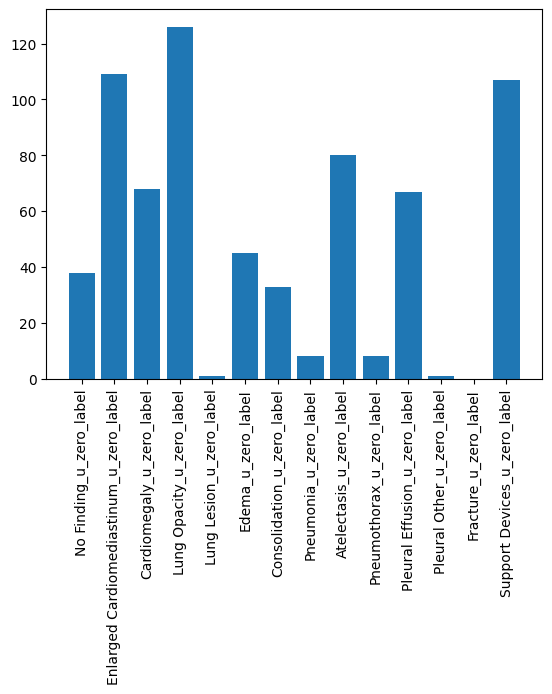

In [190]:
plt.xticks(rotation=90)
plt.bar(x = target_columns, height= y.sum(axis=0))
plt.show()

In [191]:
def true_positives(y, pred, th=0.5):
    """
    Count true positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TP (int): true positives
    """
    TP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute TP
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    
    return TP

def true_negatives(y, pred, th=0.5):
    """
    Count true negatives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TN (int): true negatives
    """
    TN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th
    
    # compute TN
    TN = np.sum((y == 0) & (thresholded_preds == 0))
    
    return TN

def false_positives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FP (int): false positives
    """
    FP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute FP
    FP = np.sum((y == 0) & (thresholded_preds == 1))
    
    return FP

def false_negatives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FN (int): false negatives
    """
    FN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th
    
    # compute FN
    FN = np.sum((y == 1) & (thresholded_preds == 0))
    
    return FN

In [192]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)


def get_true_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def get_true_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def get_false_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def get_false_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))


def get_performance_metrics(y, pred, class_labels, tp=get_true_pos,
                            tn=get_true_neg, fp=get_false_pos,
                            fn=get_false_neg,
                            acc=None, prevalence=None, spec=None,
                            sens=None, ppv=None, npv=None, auc=None, f1=None,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.iloc[i, 0] = class_labels[i]
        df.iloc[i, 1] = round(tp(y[:, i], pred[:, i]),
                             3) if tp != None else "Not Defined"
        df.iloc[i, 2] = round(tn(y[:, i], pred[:, i]),
                             3) if tn != None else "Not Defined"
        df.iloc[i, 3] = round(fp(y[:, i], pred[:, i]),
                             3) if fp != None else "Not Defined"
        df.iloc[i, 4] = round(fn(y[:, i], pred[:, i]),
                             3) if fn != None else "Not Defined"
        df.iloc[i, 5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.iloc[i, 6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.iloc[i, 7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.iloc[i, 8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.iloc[i, 9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.iloc[i, 10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        try:
            df.iloc[i, 11] = round(auc(y[:, i], pred[:, i]),
                                  3) if auc != None else "Not Defined"
        except:
            df.iloc[i, 11] = np.NAN
        df.iloc[i, 12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.iloc[i, 13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df


def print_confidence_intervals(class_labels, statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    for i in range(len(class_labels)):
        mean = statistics.mean(axis=1)[i]
        max_ = np.quantile(statistics, .95, axis=1)[i]
        min_ = np.quantile(statistics, .05, axis=1)[i]
        df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df


def get_curve(gt, pred, target_names, curve='roc'):
    for i in range(len(target_names)):
        if curve == 'roc':
            curve_function = roc_curve
            auc_roc = roc_auc_score(gt[:, i], pred[:, i])
            label = target_names[i] + " AUC: %.3f " % auc_roc
            xlabel = "False positive rate"
            ylabel = "True positive rate"
            a, b, _ = curve_function(gt[:, i], pred[:, i])
            plt.figure(1, figsize=(7, 7))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(a, b, label=label)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        elif curve == 'prc':
            precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
            average_precision = average_precision_score(gt[:, i], pred[:, i])
            label = target_names[i] + " Avg.: %.3f " % average_precision
            plt.figure(1, figsize=(7, 7))
            plt.step(recall, precision, where='post', label=label)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)

In [193]:
get_performance_metrics(y, pred, target_columns)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No Finding_u_zero_label,5,183,13,33,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Enlarged Cardiomediastinum_u_zero_label,0,125,0,109,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Cardiomegaly_u_zero_label,6,165,1,62,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Lung Opacity_u_zero_label,34,107,1,92,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Lung Lesion_u_zero_label,0,233,0,1,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Edema_u_zero_label,15,186,3,30,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Consolidation_u_zero_label,0,201,0,33,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Pneumonia_u_zero_label,0,226,0,8,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Atelectasis_u_zero_label,0,154,0,80,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5


In [194]:
def get_accuracy(y, pred, th=0.5):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        accuracy (float): accuracy of predictions at threshold
    """
    accuracy = 0.0
    
    # get TP, FP, TN, FN using our previously defined functions
    TP = true_positives(y, pred, th)
    FP = false_positives(y, pred, th)
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)

    # Compute accuracy using TP, FP, TN, FN
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    return accuracy

In [195]:
get_performance_metrics(y, pred, target_columns, acc=get_accuracy)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No Finding_u_zero_label,5,183,13,33,0.803,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Enlarged Cardiomediastinum_u_zero_label,0,125,0,109,0.534,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Cardiomegaly_u_zero_label,6,165,1,62,0.731,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Lung Opacity_u_zero_label,34,107,1,92,0.603,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Lung Lesion_u_zero_label,0,233,0,1,0.996,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Edema_u_zero_label,15,186,3,30,0.859,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Consolidation_u_zero_label,0,201,0,33,0.859,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Pneumonia_u_zero_label,0,226,0,8,0.966,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Atelectasis_u_zero_label,0,154,0,80,0.658,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5


In [196]:
def get_prevalence(y):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
    Returns:
        prevalence (float): prevalence of positive cases
    """
    prevalence = 0.0
    
    prevalence = np.sum(y) / len(y)
    
    return prevalence

In [197]:
get_performance_metrics(y, pred, target_columns, acc=get_accuracy, prevalence=get_prevalence)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No Finding_u_zero_label,5,183,13,33,0.803,0.162,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Enlarged Cardiomediastinum_u_zero_label,0,125,0,109,0.534,0.466,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Cardiomegaly_u_zero_label,6,165,1,62,0.731,0.291,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Lung Opacity_u_zero_label,34,107,1,92,0.603,0.538,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Lung Lesion_u_zero_label,0,233,0,1,0.996,0.004,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Edema_u_zero_label,15,186,3,30,0.859,0.192,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Consolidation_u_zero_label,0,201,0,33,0.859,0.141,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Pneumonia_u_zero_label,0,226,0,8,0.966,0.034,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Atelectasis_u_zero_label,0,154,0,80,0.658,0.342,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5


In [198]:
def get_sensitivity(y, pred, th=0.5):
    """
    Compute sensitivity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        sensitivity (float): probability that our test outputs positive given that the case is actually positive
    """
    sensitivity = 0.0
    
    # get TP and FN using our previously defined functions
    TP = true_positives(y, pred, th)
    FN = false_negatives(y, pred, th)

    # use TP and FN to compute sensitivity
    sensitivity = TP / (TP + FN)
    
    return sensitivity

def get_specificity(y, pred, th=0.5):
    """
    Compute specificity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        specificity (float): probability that the test outputs negative given that the case is actually negative
    """
    specificity = 0.0
    
    # get TN and FP using our previously defined functions
    TN = true_negatives(y, pred, th)
    FP = false_positives(y, pred, th)
    
    # use TN and FP to compute specificity 
    specificity = TN / (TN + FP)
    
    return specificity

In [199]:
get_performance_metrics(y, pred, target_columns, acc=get_accuracy, prevalence=get_prevalence, sens=get_sensitivity, spec=get_specificity)

<ipython-input-198-d4356af2ea6f>:19: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = TP / (TP + FN)


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No Finding_u_zero_label,5,183,13,33,0.803,0.162,0.132,0.934,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Enlarged Cardiomediastinum_u_zero_label,0,125,0,109,0.534,0.466,0.000,1.000,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Cardiomegaly_u_zero_label,6,165,1,62,0.731,0.291,0.088,0.994,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Lung Opacity_u_zero_label,34,107,1,92,0.603,0.538,0.270,0.991,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Lung Lesion_u_zero_label,0,233,0,1,0.996,0.004,0.000,1.000,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Edema_u_zero_label,15,186,3,30,0.859,0.192,0.333,0.984,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Consolidation_u_zero_label,0,201,0,33,0.859,0.141,0.000,1.000,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Pneumonia_u_zero_label,0,226,0,8,0.966,0.034,0.000,1.000,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Atelectasis_u_zero_label,0,154,0,80,0.658,0.342,0.000,1.000,Not Defined,Not Defined,Not Defined,Not Defined,0.5


In [200]:
def get_ppv(y, pred, th=0.5):
    """
    Compute PPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        PPV (float): positive predictive value of predictions at threshold
    """
    PPV = 0.0
    
    # get TP and FP using our previously defined functions
    TP = true_positives(y, pred, th)
    FP = false_positives(y, pred, th)

    # use TP and FP to compute PPV
    PPV = TP / (TP + FP)
    
    return PPV

def get_npv(y, pred, th=0.5):
    """
    Compute NPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        NPV (float): negative predictive value of predictions at threshold
    """
    NPV = 0.0
    
    # get TN and FN using our previously defined functions
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)

    # use TN and FN to compute NPV
    NPV = TN / (TN + FN)
    
    return NPV

In [201]:
get_performance_metrics(y, pred, target_columns, acc=get_accuracy, prevalence=get_prevalence, sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv)

<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-198-d4356af2ea6f>:19: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = TP / (TP + FN)


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No Finding_u_zero_label,5,183,13,33,0.803,0.162,0.132,0.934,0.278,0.847,Not Defined,Not Defined,0.5
Enlarged Cardiomediastinum_u_zero_label,0,125,0,109,0.534,0.466,0.000,1.000,NaN,0.534,Not Defined,Not Defined,0.5
Cardiomegaly_u_zero_label,6,165,1,62,0.731,0.291,0.088,0.994,0.857,0.727,Not Defined,Not Defined,0.5
Lung Opacity_u_zero_label,34,107,1,92,0.603,0.538,0.270,0.991,0.971,0.538,Not Defined,Not Defined,0.5
Lung Lesion_u_zero_label,0,233,0,1,0.996,0.004,0.000,1.000,NaN,0.996,Not Defined,Not Defined,0.5
Edema_u_zero_label,15,186,3,30,0.859,0.192,0.333,0.984,0.833,0.861,Not Defined,Not Defined,0.5
Consolidation_u_zero_label,0,201,0,33,0.859,0.141,0.000,1.000,NaN,0.859,Not Defined,Not Defined,0.5
Pneumonia_u_zero_label,0,226,0,8,0.966,0.034,0.000,1.000,NaN,0.966,Not Defined,Not Defined,0.5
Atelectasis_u_zero_label,0,154,0,80,0.658,0.342,0.000,1.000,NaN,0.658,Not Defined,Not Defined,0.5


In [202]:
# get_curve(y, pred, target_columns)

In [203]:
from sklearn.metrics import roc_auc_score
get_performance_metrics(y, pred, target_columns, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score)

<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-198-d4356af2ea6f>:19: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = TP / (TP + FN)


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No Finding_u_zero_label,5,183,13,33,0.803,0.162,0.132,0.934,0.278,0.847,0.837,Not Defined,0.5
Enlarged Cardiomediastinum_u_zero_label,0,125,0,109,0.534,0.466,0.000,1.000,NaN,0.534,0.745,Not Defined,0.5
Cardiomegaly_u_zero_label,6,165,1,62,0.731,0.291,0.088,0.994,0.857,0.727,0.773,Not Defined,0.5
Lung Opacity_u_zero_label,34,107,1,92,0.603,0.538,0.270,0.991,0.971,0.538,0.928,Not Defined,0.5
Lung Lesion_u_zero_label,0,233,0,1,0.996,0.004,0.000,1.000,NaN,0.996,0.717,Not Defined,0.5
Edema_u_zero_label,15,186,3,30,0.859,0.192,0.333,0.984,0.833,0.861,0.904,Not Defined,0.5
Consolidation_u_zero_label,0,201,0,33,0.859,0.141,0.000,1.000,NaN,0.859,0.898,Not Defined,0.5
Pneumonia_u_zero_label,0,226,0,8,0.966,0.034,0.000,1.000,NaN,0.966,0.663,Not Defined,0.5
Atelectasis_u_zero_label,0,154,0,80,0.658,0.342,0.000,1.000,NaN,0.658,0.811,Not Defined,0.5


In [204]:
def bootstrap_auc(y, pred, classes, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))

    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            try:
                score = roc_auc_score(y_sample, pred_sample)
            except:
                score = 0
            statistics[c][i] = score
    return statistics

statistics = bootstrap_auc(y, pred, target_columns)

<ipython-input-204-e7bdf0d41415>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'pred'] = pred[:, c]
<ipython-input-204-e7bdf0d41415>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'pred'] = pred[:, c]
<ipython-input-204-e7bdf0d41415>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, '

In [205]:
print_confidence_intervals(target_columns, statistics)

,Mean AUC (CI 5%-95%)
No Finding_u_zero_label,0.84 (0.82-0.86)
Enlarged Cardiomediastinum_u_zero_label,0.74 (0.72-0.77)
Cardiomegaly_u_zero_label,0.77 (0.75-0.80)
Lung Opacity_u_zero_label,0.93 (0.91-0.94)
Lung Lesion_u_zero_label,0.71 (0.69-0.74)
Edema_u_zero_label,0.90 (0.88-0.92)
Consolidation_u_zero_label,0.90 (0.88-0.91)
Pneumonia_u_zero_label,0.66 (0.58-0.73)
Atelectasis_u_zero_label,0.81 (0.79-0.83)
Pneumothorax_u_zero_label,0.78 (0.72-0.83)


In [206]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y, pred):
    plt.figure(figsize=(20, 20))
    for i in range(len(target_columns)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:,i], pred[:,i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(target_columns[i])
    plt.tight_layout()
    plt.show()

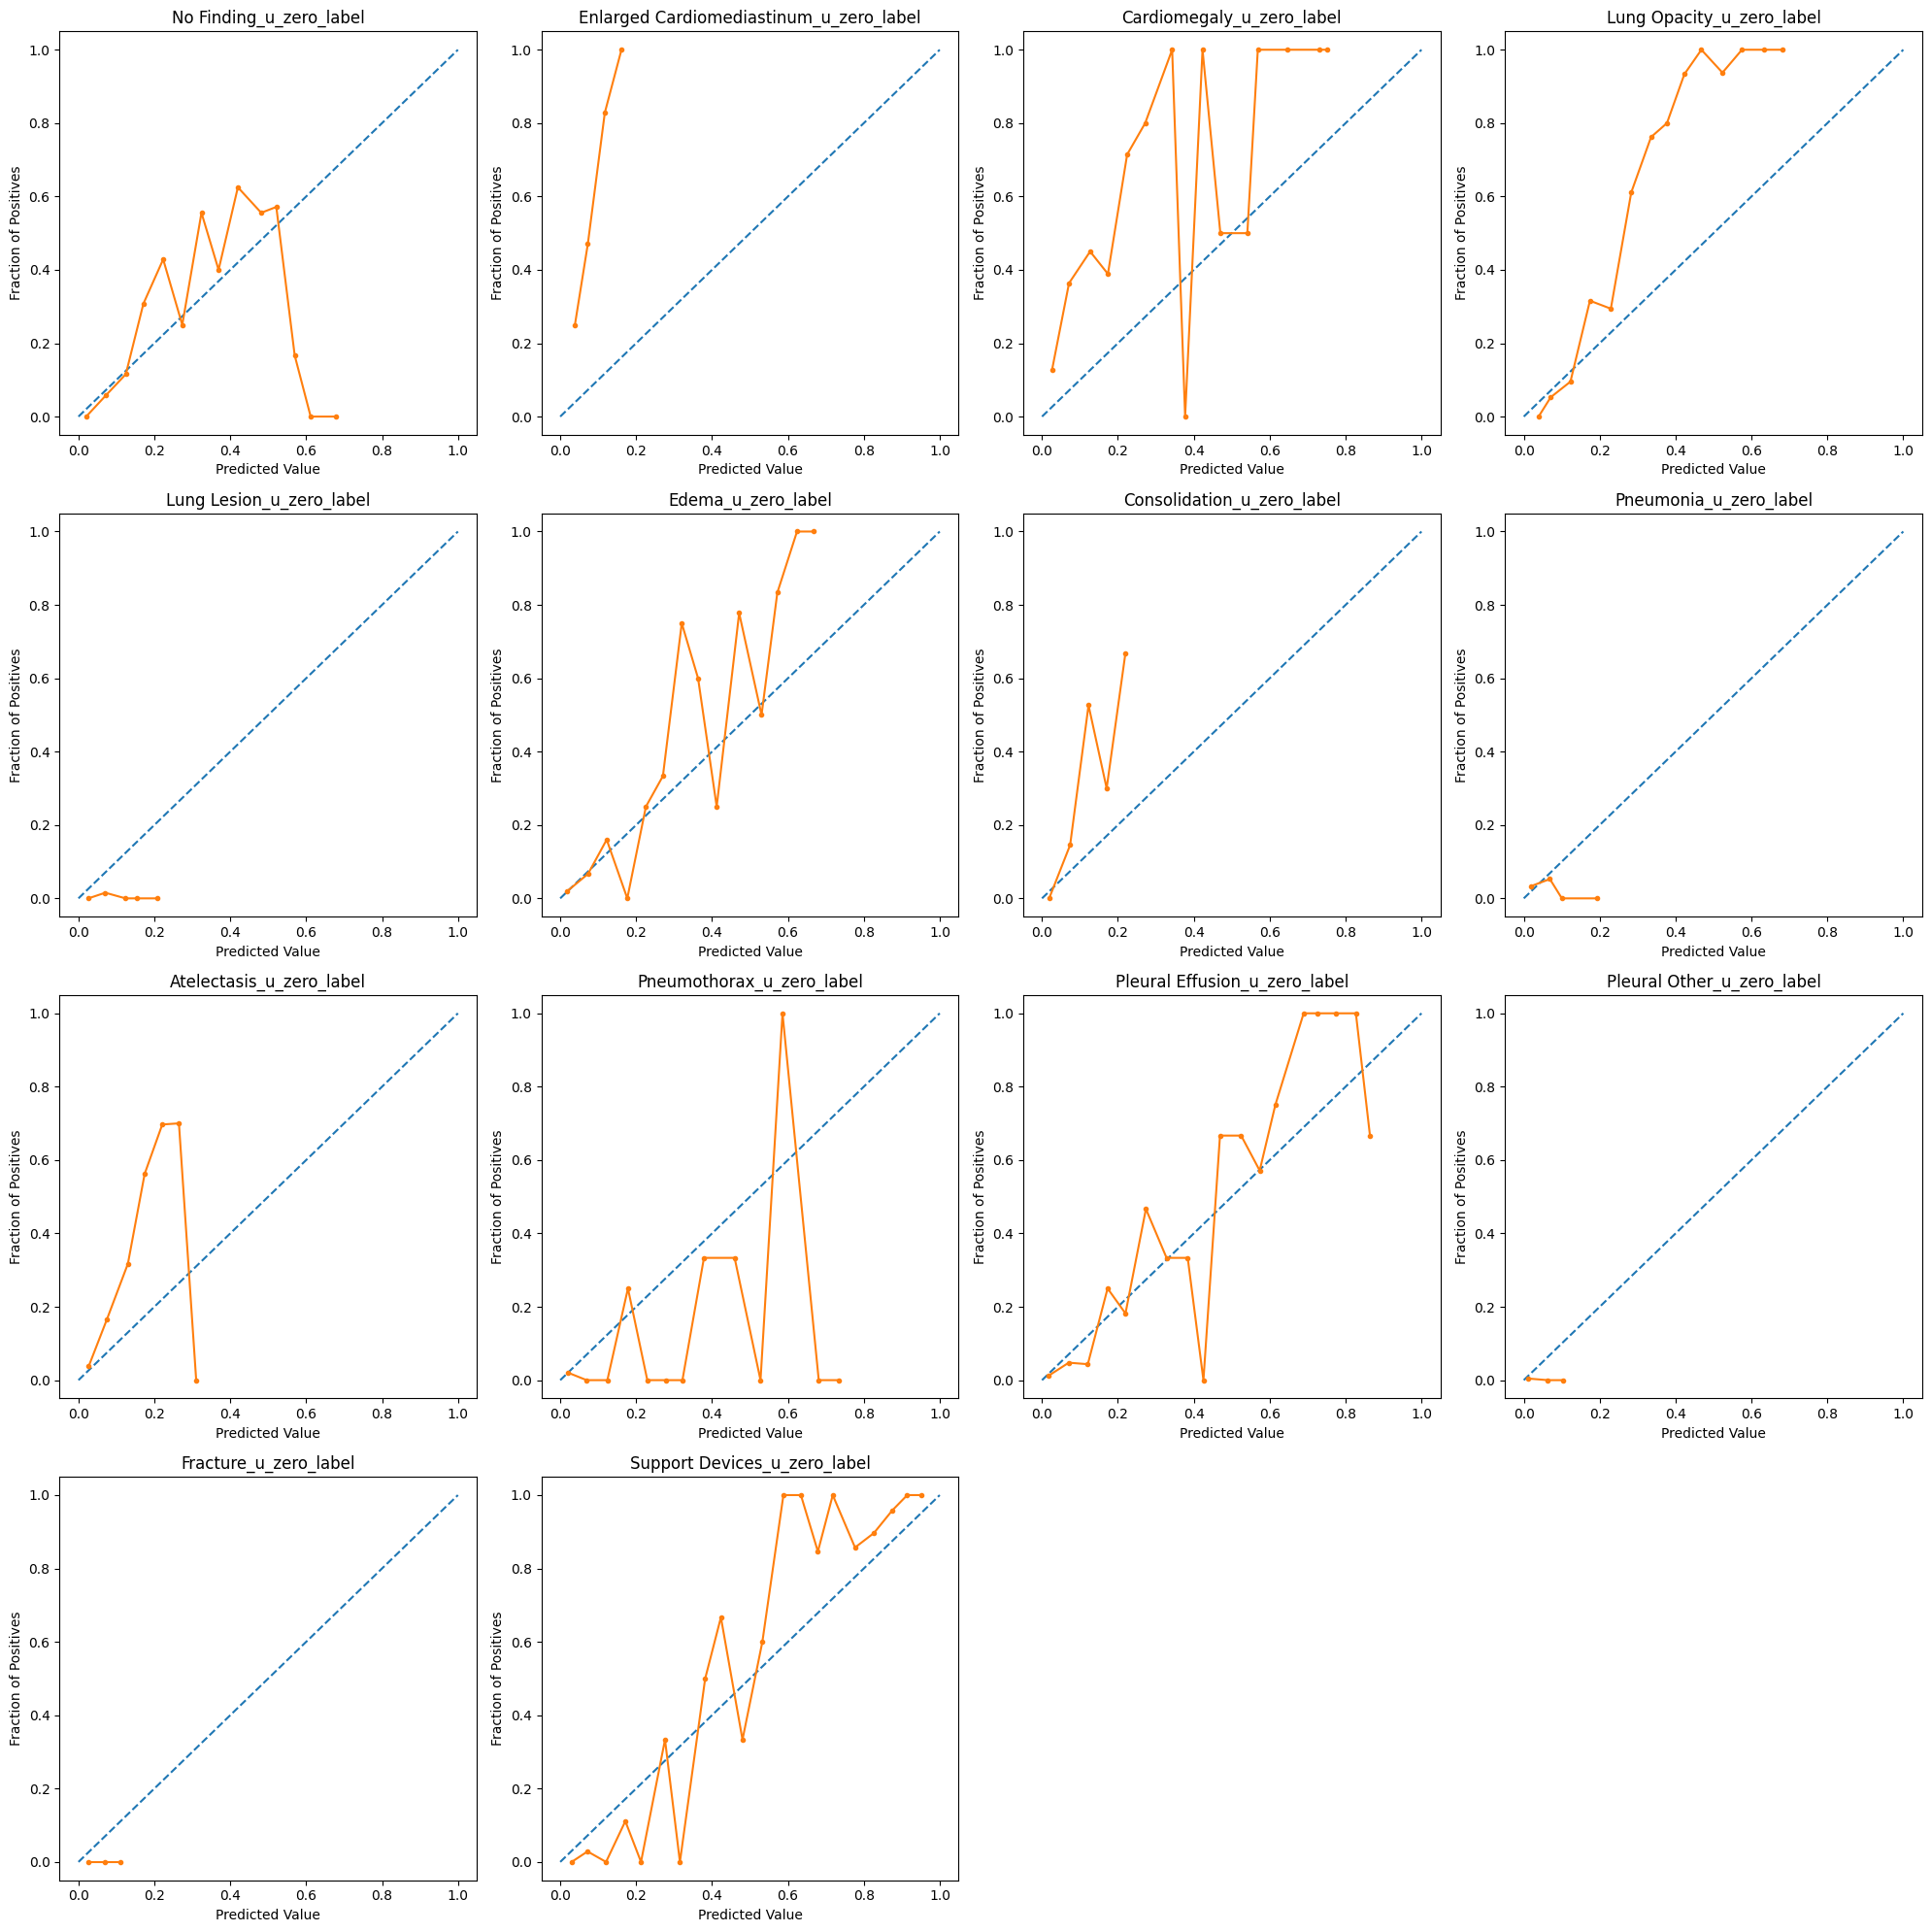

In [207]:
plot_calibration_curve(y, pred)

In [208]:
from sklearn.metrics import f1_score
model_performance_df = get_performance_metrics(y, pred, target_columns, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-200-d31264456682>:19: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
<ipython-input-198-d4356af2ea6f>:19: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = TP / (TP + FN)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor

In [209]:
model_performance_df

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No Finding_u_zero_label,5,183,13,33,0.803,0.162,0.132,0.934,0.278,0.847,0.837,0.179,0.5
Enlarged Cardiomediastinum_u_zero_label,0,125,0,109,0.534,0.466,0.000,1.000,NaN,0.534,0.745,0.000,0.5
Cardiomegaly_u_zero_label,6,165,1,62,0.731,0.291,0.088,0.994,0.857,0.727,0.773,0.160,0.5
Lung Opacity_u_zero_label,34,107,1,92,0.603,0.538,0.270,0.991,0.971,0.538,0.928,0.422,0.5
Lung Lesion_u_zero_label,0,233,0,1,0.996,0.004,0.000,1.000,NaN,0.996,0.717,0.000,0.5
Edema_u_zero_label,15,186,3,30,0.859,0.192,0.333,0.984,0.833,0.861,0.904,0.476,0.5
Consolidation_u_zero_label,0,201,0,33,0.859,0.141,0.000,1.000,NaN,0.859,0.898,0.000,0.5
Pneumonia_u_zero_label,0,226,0,8,0.966,0.034,0.000,1.000,NaN,0.966,0.663,0.000,0.5
Atelectasis_u_zero_label,0,154,0,80,0.658,0.342,0.000,1.000,NaN,0.658,0.811,0.000,0.5


In [211]:
model_performance_df.to_csv(f'model_performance/test_metrics_{MODEL_NAME}.csv')

In [156]:
print_confidence_intervals(target_columns, statistics)

,Mean AUC (CI 5%-95%)
No Finding_u_zero_label,0.85 (0.82-0.87)
Enlarged Cardiomediastinum_u_zero_label,0.62 (0.59-0.64)
Cardiomegaly_u_zero_label,0.84 (0.82-0.86)
Lung Opacity_u_zero_label,0.93 (0.92-0.94)
Lung Lesion_u_zero_label,0.12 (0.11-0.14)
Edema_u_zero_label,0.91 (0.90-0.93)
Consolidation_u_zero_label,0.90 (0.88-0.91)
Pneumonia_u_zero_label,0.57 (0.52-0.64)
Atelectasis_u_zero_label,0.80 (0.78-0.82)
Pneumothorax_u_zero_label,0.95 (0.93-0.96)


## Define Grad-CAM Algorithm

In [69]:
X_test.head(15)

0     /data/nodule_data_20210813_partial/MetsThorax/...
1     /data/nodule_data_20210813_partial/NoNodulesTh...
2     /data/nodule_data_20210813_partial/NoNodulesTh...
3     /data/nodule_data_20210813_partial/NoNodulesTh...
4     /data/nodule_data_20210813_partial/MetsThorax/...
5     /data/nodule_data_20210813_partial/MetsThorax/...
6     /data/nodule_data_20210813_partial/MetsThorax/...
7     /data/nodule_data_20210813_partial/NoNodulesTh...
8     /data/nodule_data_20210813_partial/NoNodulesTh...
9     /data/nodule_data_20210813_partial/MetsThorax/...
10    /data/nodule_data_20210813_partial/MetsThorax/...
11    /data/nodule_data_20210813_partial/NoNodulesTh...
12    /data/nodule_data_20210813_partial/NoNodulesTh...
13    /data/nodule_data_20210813_partial/MetsThorax/...
14    /data/nodule_data_20210813_partial/NoNodulesTh...
Name: path, dtype: object

In [91]:
MY_IMG_PATH = X_test[6]

In [92]:
MY_IMG_PATH

'/data/nodule_data_20210813_partial/MetsThorax/417794_18052011_0077.jpg'

In [93]:
# DenseNet201, Xception
last_conv_layer_name = 'block14_sepconv2'
classifier_layer_names = ['local_avg_pool', 'flatten', 'prediction']

Run model on a single image

In [65]:
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [66]:
test_num = 9

X_test_example = X_test[test_num]
y_test_example = y_test[test_num]

y_hat = model_predict(path=X_test_example, model=model)

print(f'Ground truth label: {y_test_example} \n Predicted label: {np.argmax(y_hat)} \t Probability: {np.max(y_hat)}')

1/1 [==============================] - 3s 3s/step
Ground truth label: 1 
 Predicted label: 1 	 Probability: 0.9991495609283447


Run model on the entire test set

In [67]:
test_data = create_model_file(X_path=X_test, y=y_test)

In [68]:
model.evaluate(x=test_data[0], y=test_data[1])

1/1 [==============================] - 1s 768ms/step - loss: 0.1733 - accuracy: 0.9524


[0.17331543564796448, 0.9523809552192688]

In [94]:
# # EfficientNetV2S
# last_conv_layer_name = 'top_conv'
# classifier_layer_names = ['top_bn', 'top_activation', 'local_avg_pool', 'flatten', 'prediction']

In [95]:
def get_img_array(img_path):
    img = convert_image_to_array(path=img_path)
    # We add a dimension to transform our array into a "batch"
    img = np.expand_dims(img, axis=0)
    return img


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

First look at active regions

1/1 [==============================] - 0s 69ms/step
Predicted class: nodule 
 Probability: 0.9999918937683105


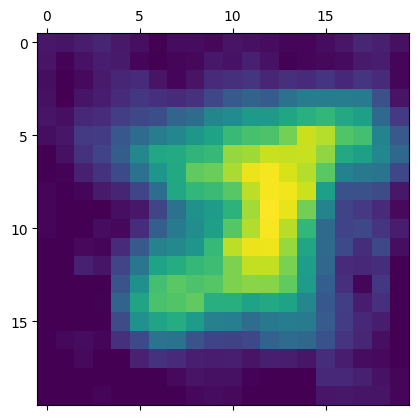

In [96]:
# Prepare image
img_array = get_img_array(img_path=MY_IMG_PATH)

# Print what the top predicted class is
preds = model.predict(img_array)
pred_class = np.argmax(preds)
pred_label = 'normal' if pred_class == 0 else 'nodule'
pred_prob = np.max(preds)
#print(f"Predicted class: {pred_label} \n Probability: {pred_prob} \n Actual Class: {lesion_type_dict[label_abbreviation]}")
print(f"Predicted class: {pred_label} \n Probability: {pred_prob}")

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Overlay the heatmap on the original image

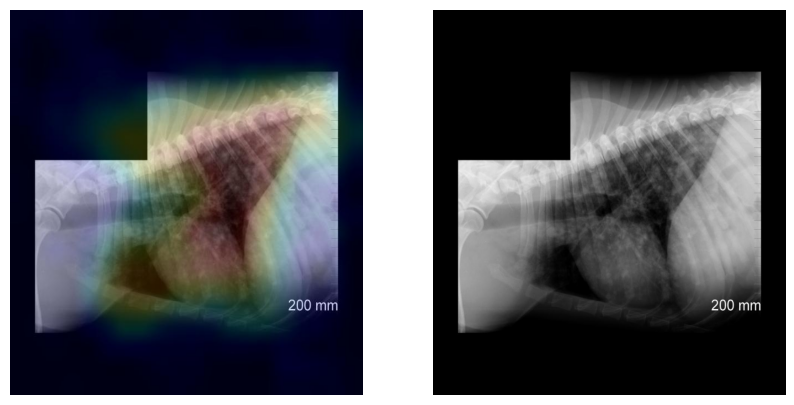

In [97]:
# We load the original image
#img = np.asarray(Image.open(SAMPLE_PATH))
img = convert_image_to_array(path=MY_IMG_PATH)
# img = np.expand_dims(img, axis=0)
# img = img.squeeze()
img = np.uint8(255. * img)
# img = np.uint8(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255. * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.2 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "heatmap.jpg"
superimposed_img.save(save_path)

# Display Grad CAM along with original image
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

axs[0].imshow(np.asarray(Image.open(save_path)))
axs[0].axis('off')
axs[0].set_aspect('auto')
#axs[1].imshow(np.asarray(Image.open(SAMPLE_PATH)))
# axs[1].imshow(np.asarray(Image.open(MY_IMG_PATH)))
axs[1].imshow(np.asarray(img))
axs[1].axis('off')
axs[1].set_aspect('auto')

plt.show() 